# Итоговый проект на курсе Data Science школа SkillFactory
# «Модель прогнозирования стоимости жилья для агентства недвижимости»

**Цель:** разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

In [43]:
# Импорт библиотек
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly.subplots as spimport
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [44]:
# Фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [45]:
# Фиксация версий пакетов
!pip freeze > requirements.txt

## 2. Разведывательный анализ (EDA) и преобразование данных

Загружаем очищенный датасет.

In [46]:
df = pd.read_csv('data/cleaned_data.csv')
df.head()

,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool,beds_overall,avg_schools_rating,school_distance_min,Year built
0,Active,single family,240 Heather Ln,3.5,Southern Pines,2900,28387,NC,418000,False,4.0,5.200000,2.70,2019
1,For sale,single family,12911 E Heroy Ave,3.0,Spokane Valley,1947,99216,WA,310000,False,3.0,4.000000,1.01,2019
2,For sale,single family,2005 Westridge Rd,2.0,Los Angeles,3000,90049,CA,2895000,True,3.0,6.666667,1.19,1961
3,For sale,single family,4311 Livingston Ave,8.0,Dallas,6457,75205,TX,2395000,False,5.0,9.250000,0.10,2006
4,For sale,land,1524 Kiscoe St,0.0,Palm Bay,0,32908,FL,5000,False,0.0,4.666667,3.03,unknown


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374249 entries, 0 to 374248
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               374249 non-null  object 
 1   propertyType         374249 non-null  object 
 2   street               374249 non-null  object 
 3   baths                374249 non-null  float64
 4   city                 374249 non-null  object 
 5   sqft                 374249 non-null  int64  
 6   zipcode              374249 non-null  int64  
 7   state                374249 non-null  object 
 8   target               374249 non-null  int64  
 9   private_pool         374249 non-null  bool   
 10  beds_overall         374249 non-null  float64
 11  avg_schools_rating   374249 non-null  float64
 12  school_distance_min  374249 non-null  float64
 13  Year built           374249 non-null  object 
dtypes: bool(1), float64(4), int64(3), object(6)
memory usage: 37.5+ MB


### Анализ числовых признаков, очистка от выбросов

В числовые признаки загрузился признак zipcode, который на самом деле является категориальным.

In [48]:
# Изменение типа данных признака zipcode
df['zipcode'] = df['zipcode'].astype(str)

In [49]:
df.describe()

,baths,sqft,target,beds_overall,avg_schools_rating,school_distance_min
count,374249.000000,3.742490e+05,3.742490e+05,374249.000000,374249.000000,374249.000000
mean,2.337149,6.557172e+03,6.452504e+05,2.365513,5.083910,1.200335
std,18.907441,1.501014e+06,1.839708e+06,2.078903,2.051534,5.424609
min,0.000000,0.000000e+00,1.000000e+00,0.000000,-1.000000,-1.000000
25%,0.000000,1.056000e+03,1.879000e+05,0.000000,3.666667,0.340000
50%,2.000000,1.677000e+03,3.200000e+05,3.000000,5.000000,0.670000
75%,3.000000,2.495000e+03,5.845000e+05,4.000000,6.500000,1.300000
max,750.000000,7.959794e+08,1.950000e+08,144.000000,10.000000,1590.380000


Вызывают сомнения минимальные (0) и максимальное (7.959794e+08) значения площади, минимум (0) и максимум (144) спален, максимальное значение ванных комнат (750), минимум (1) и максимум (1.95e+08) таргета, максимум (1590.38) расстояния до школы, значения -1 расстояния до школы и среднего рейтинга школ являются скрытыми пропусками.

In [50]:
# Список числовых признаков:
num_features = ['baths', 'sqft', 'beds_overall', 'avg_schools_rating', 'school_distance_min', 'target']

Построим графики рассеивания и коробчатые диаграммы для числовых признаков. Иследуем распределение значений, наличие выбросов.

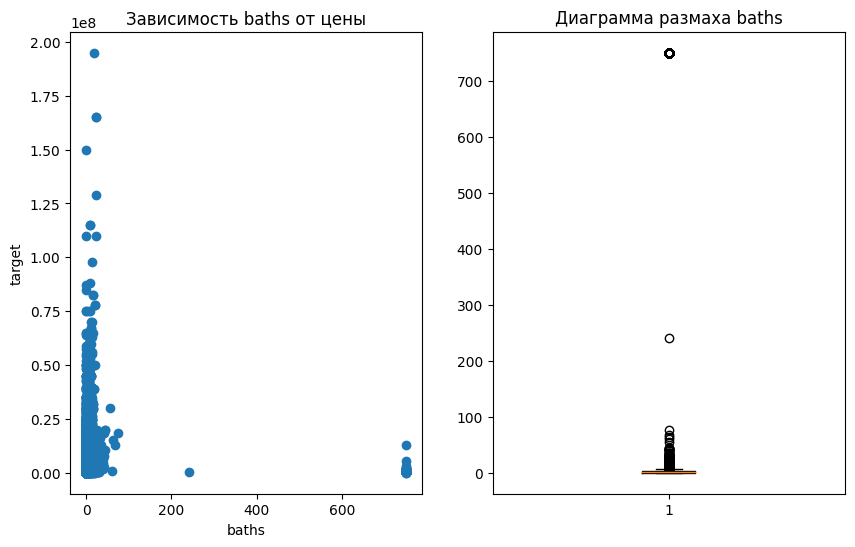

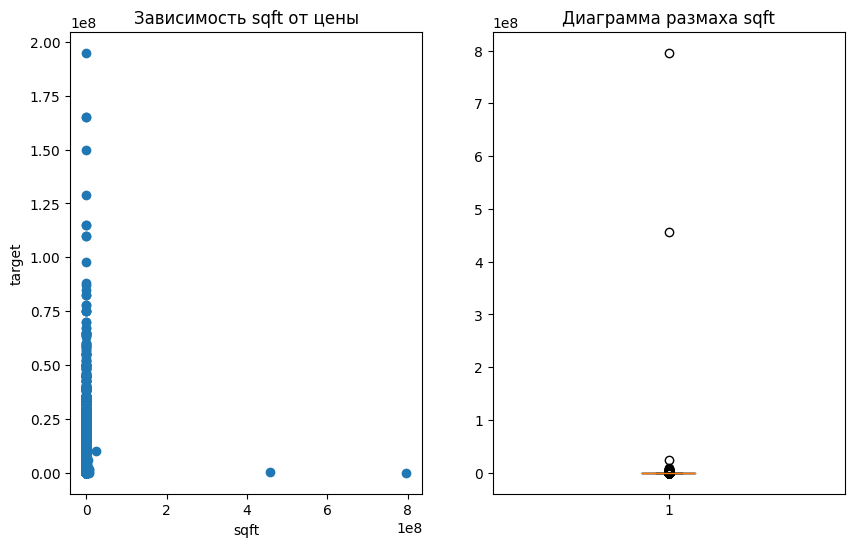

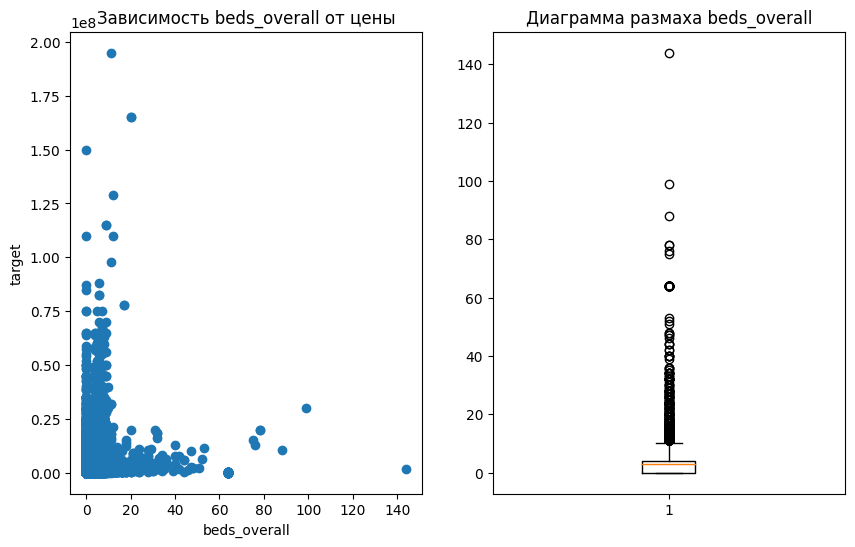

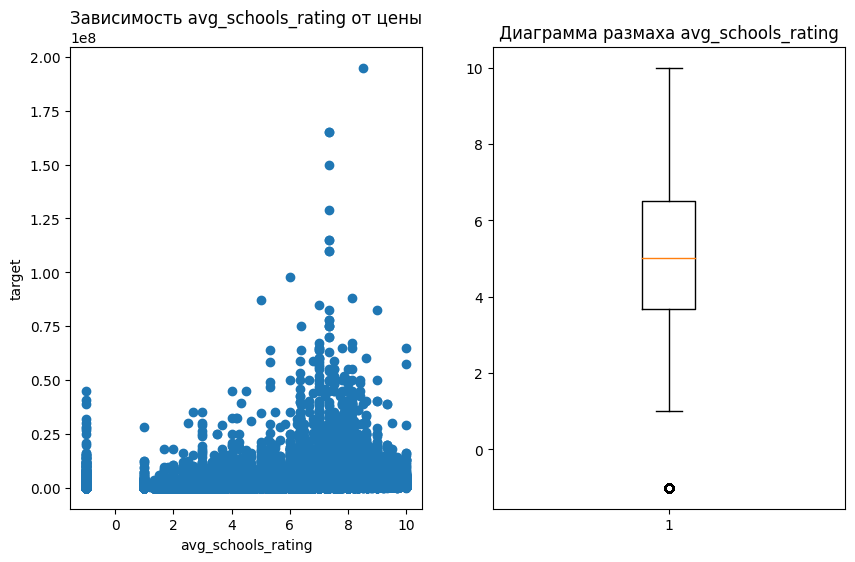

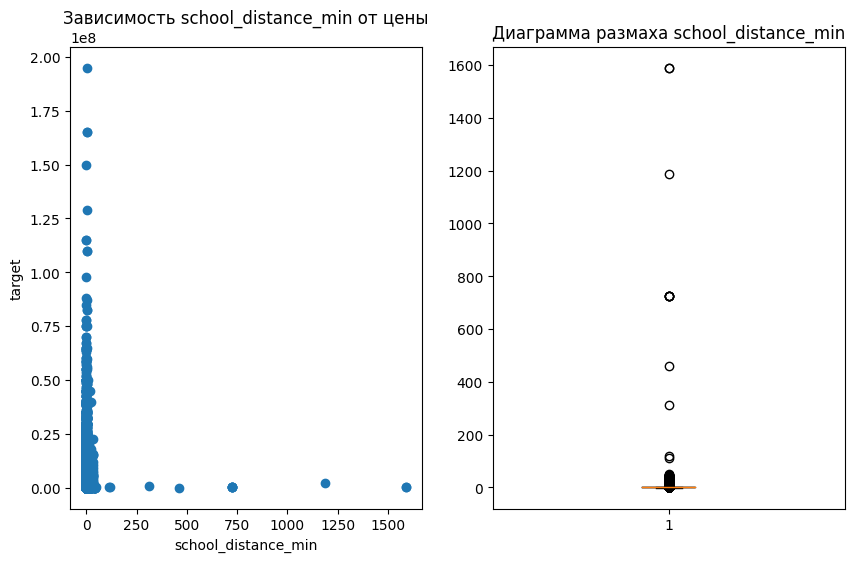

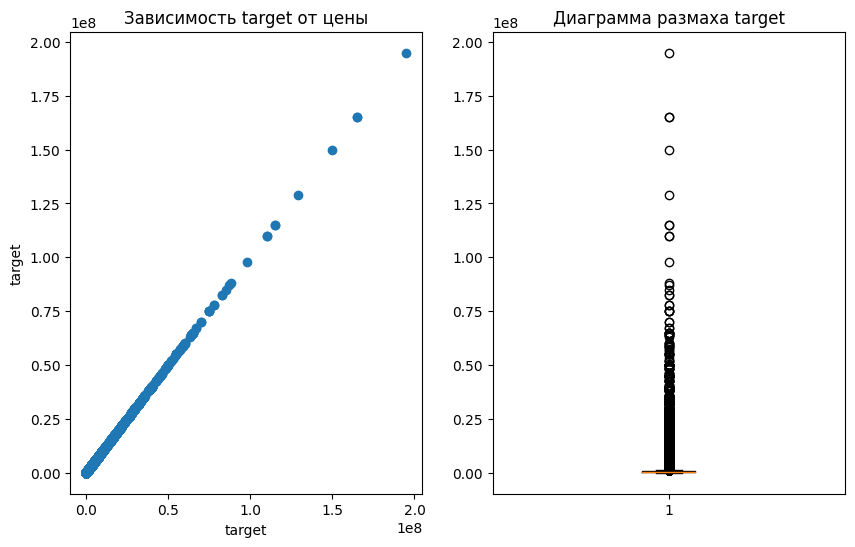

In [51]:
# Папка для хранения графиков
output_directory = 'graph'
os.makedirs(output_directory, exist_ok=True)

# Построение для числовых признаков диаграмм рассеивания с таргетом, а также диаграмм размаха
for feature in num_features:
    fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(10, 6))
 
    ax2.scatter(data=df, x=feature, y='target')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'Зависимость {feature} от цены')

    ax3.boxplot(data=df, x=feature)
    ax3.set_title(f'Диаграмма размаха {feature}')

    # Сохранение графиков
    image_filename = os.path.join(output_directory, f'1_{feature}_plot.png')
    fig.savefig(image_filename)

Выводы исходя из графиков:
- в признаке baths значения больше 100 являются выбросами, поскольку цена за объект слишком низкая для такого количества ванных комнат;
- записи площади со значением 0 необходимо удалить, так как они будут плохо влиять на прогноз, значения площади более 100000000 являются выбросами;
- минимальное расстояние до школы больше 200 является выбросами;
- значения -1 расстояния до школы и среднего рейтинга школ являются скрытыми пропусками.

 Проверим распределение числовых признаков, построив гистограммы

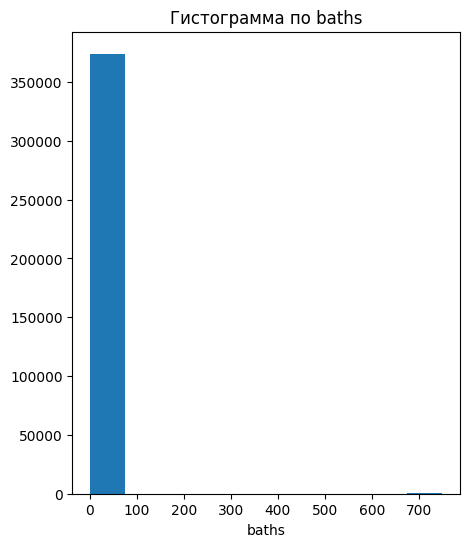

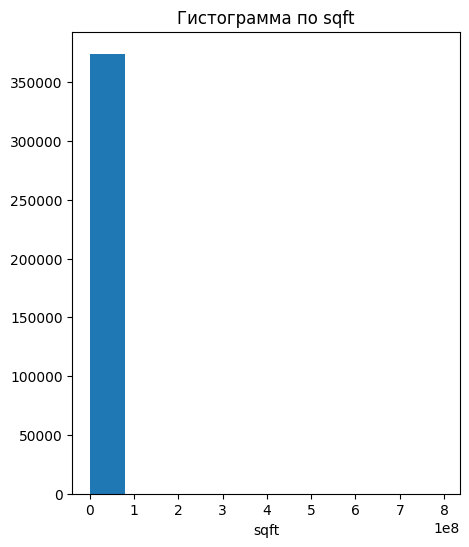

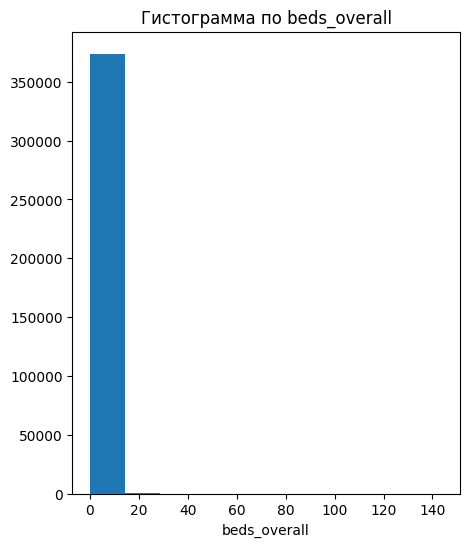

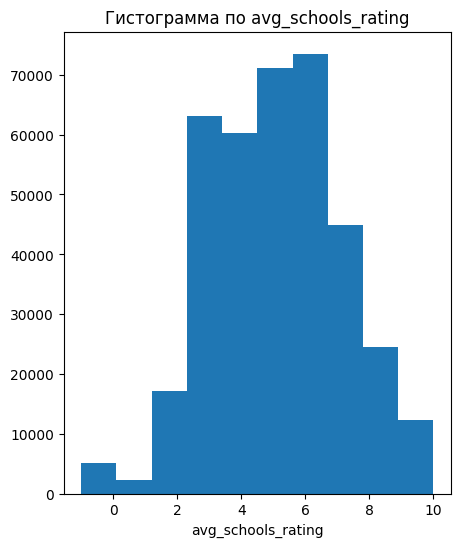

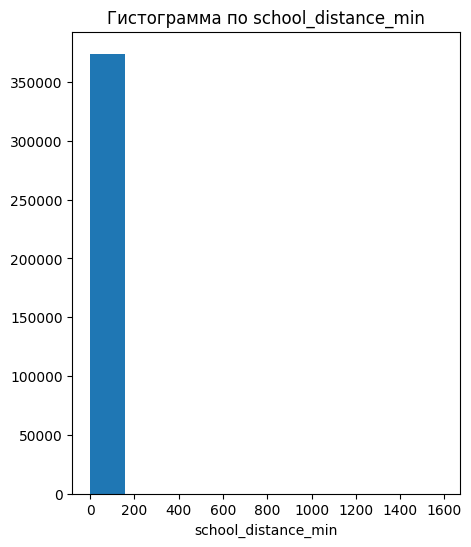

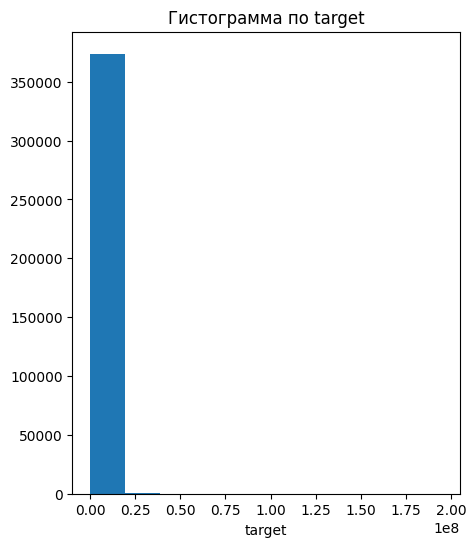

In [52]:
# Построение гистограмм
for feature in num_features:
    fig, (ax) = plt.subplots(1, figsize=(5, 6))

    ax.hist(df[feature])
    ax.set_xlabel(feature)
    ax.set_title(f'Гистограмма по {feature}')

    # Сохранение графиков
    image_filename = os.path.join(output_directory, f'1_{feature}_plot.png')
    fig.savefig(image_filename)



Вывод- распределение ни одного из числовых признаков не является нормальным, для получения гауссового распределения необходимо провести логарифмирование и нормализацию.

### Признак baths

In [53]:
# Удаление выбросов признака baths
condition_1 = df['baths'] > 100
df.drop(df[condition_1].index, inplace=True)

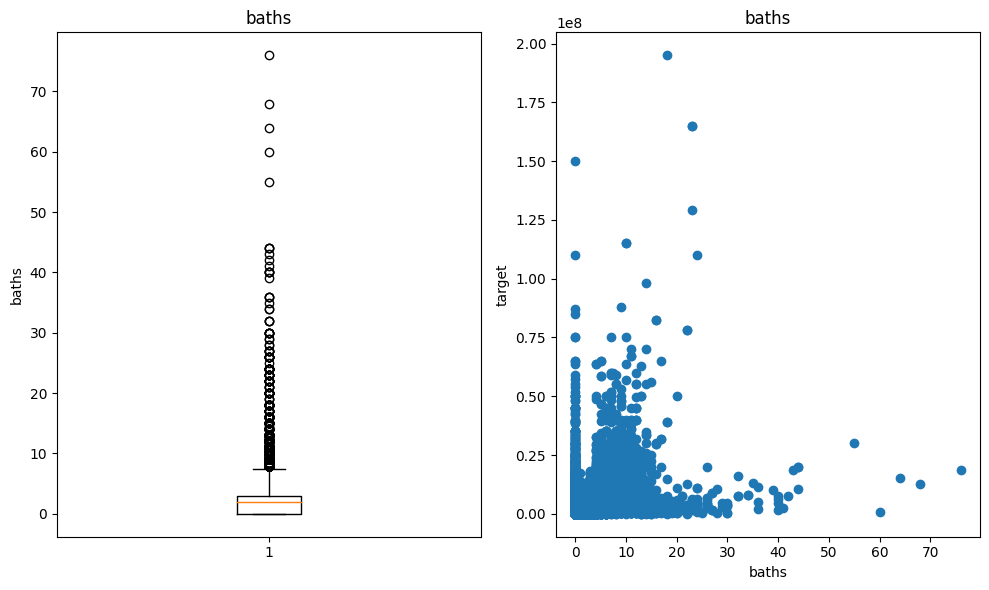

In [54]:
# График после удаления очевидных выбросов
num_features_1 = ['baths']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.scatter(data=df, x=feature, y='target')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    # Сохранение графиков
    image_filename = os.path.join(output_directory, f'2_{feature}_plot.png')
    fig.savefig(image_filename)

Воспользуемся методом межквартильного размаха для обнаружения и удаления выбросов для признака baths.

In [55]:
# Поиск выбросов в признаке baths по методу Тьюки
# Функция нахождения выбросов по методу межквартильного размаха
def find_outliers_iqr(data, feature, left=1.5, right=1.5, log_scale=False):
    
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

def find_outliers_z_score(data, feature, left=3, right=3, log_scale=False):
    
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

def find_outliers_quantile(data, feature, left=0.01, right=0.99):
    x = data[feature]
    lower_bound = x.quantile(left)
    upper_bound = x.quantile(right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

    
outliers1, cleaned1 = find_outliers_iqr(df, 'baths', left=2, right=2, log_scale=False)
print(f'Число выбросов по методу Тьюки: {outliers1.shape[0]}')
print(f'Результирующее число записей: {cleaned1.shape[0]}')

# Удаление выбросов
df = df.drop(outliers1.index)

Число выбросов по методу Тьюки: 1022
Результирующее число записей: 372989


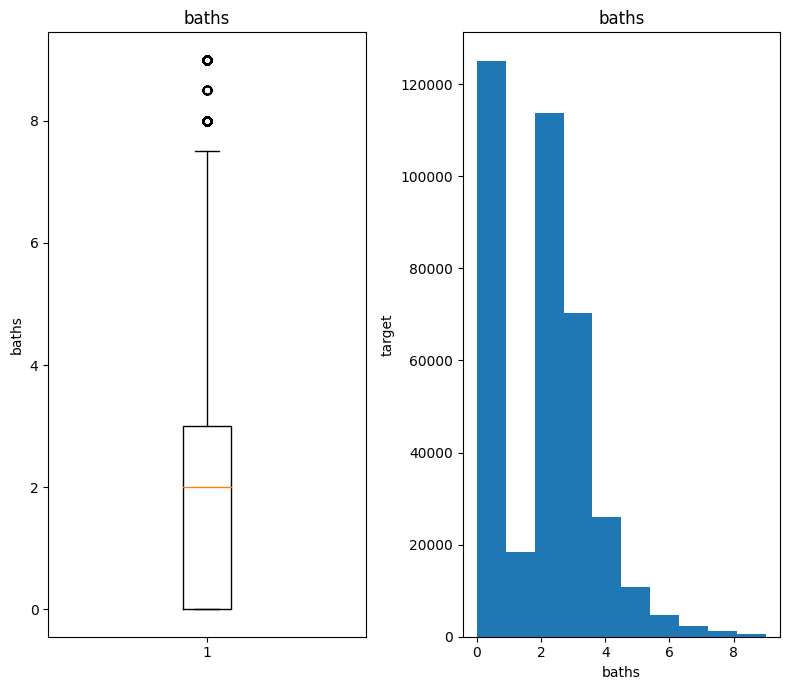

In [56]:
# График после удаления выбросов
num_features_1 = ['baths']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='baths')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    # Сохранение графика
    image_filename = os.path.join(output_directory, f'3_{feature}_plot.png')
    fig.savefig(image_filename)

### Признак sqft

In [57]:
# Удаление выбросов признака sqft
condition_2 = df['sqft'] > 100000000
df.drop(df[condition_2].index, inplace=True)
condition_3 = df['sqft'] == 0
df.drop(df[condition_3].index, inplace=True)


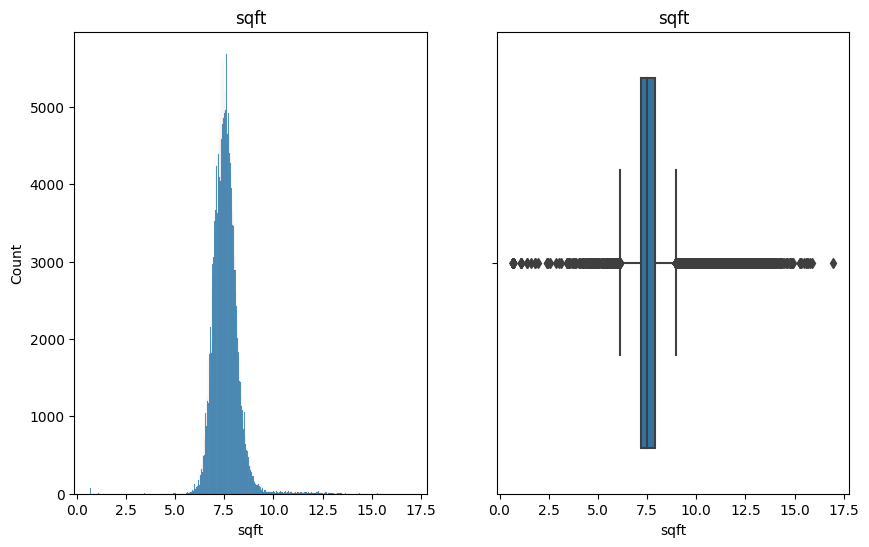

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
histplot = sns.histplot(data=df, x=np.log(df['sqft']+1), ax=axes[0])
histplot.set_title('sqft')
boxplot = sns.boxplot(data=df, x=np.log(df['sqft']+1), ax=axes[1])
boxplot.set_title('sqft')

# Cохранение графика
fig.savefig('graph/2_sqft.png') 

Удалось добится симметрии графика распределения площади. Удалим выбросы по методу Тьюки с логарифмированием и двусторонним смещением. 

Число выбросов по методу Тьюки: 4106
Результирующее число записей: 318983


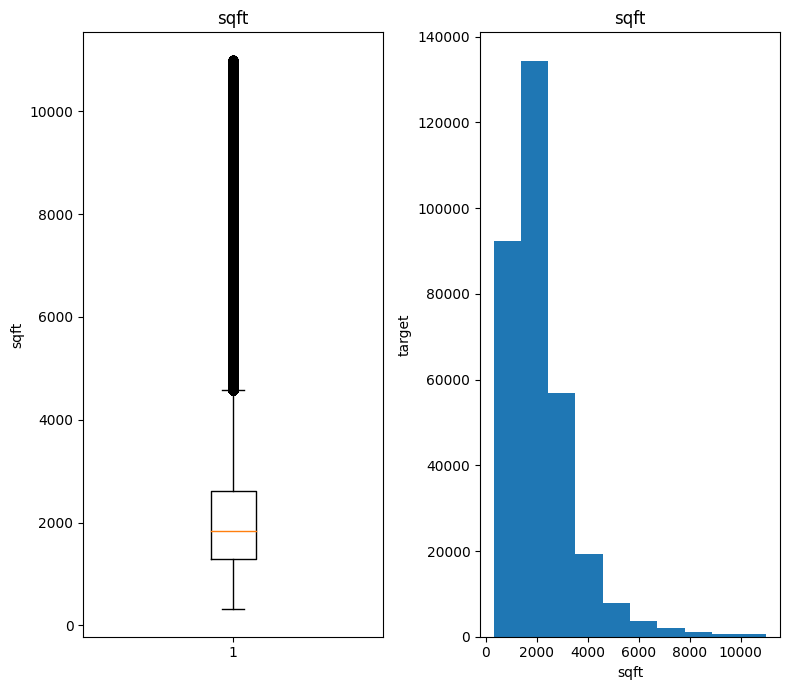

In [59]:
# Удаление выбросов в sqft
outliers2, cleaned2 = find_outliers_iqr(df, 'sqft', left=2, right=2, log_scale=True)
print(f'Число выбросов по методу Тьюки: {outliers2.shape[0]}')
print(f'Результирующее число записей: {cleaned2.shape[0]}')

df = df.drop(outliers2.index)

# График
num_features_1 = ['sqft']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='sqft')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    image_filename = os.path.join(output_directory, f'4_{feature}_plot.png')
    fig.savefig(image_filename)

### Признак school_distance_min

Число выбросов по методу Тьюки: 18816
Результирующее число записей: 297271


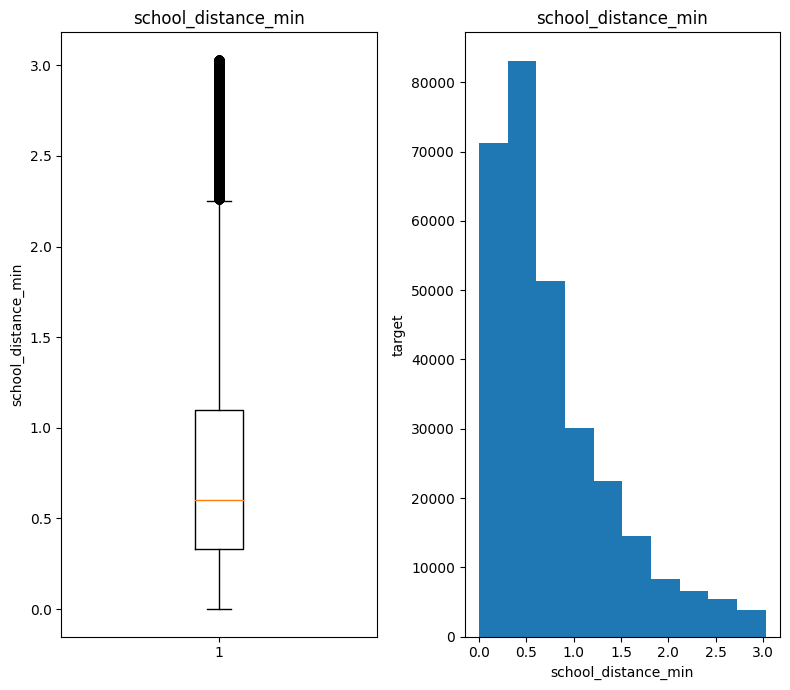

In [60]:
# Удаление выбросов признака  school_distance_min
condition_4 = df['school_distance_min'] < 0
df.drop(df[condition_4].index, inplace=True)

outliers3, cleaned3 = find_outliers_iqr(df, 'school_distance_min', left=2, right=2, log_scale=False)
print(f'Число выбросов по методу Тьюки: {outliers3.shape[0]}')
print(f'Результирующее число записей: {cleaned3.shape[0]}')

df = df.drop(outliers3.index)

# График после удаления выбросов
num_features_1 = ['school_distance_min']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='school_distance_min')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    image_filename = os.path.join(output_directory, f'2_{feature}_plot.png')
    fig.savefig(image_filename)

### Признак avg_schools_rating

Число выбросов по методу Тьюки: 0
Результирующее число записей: 296656


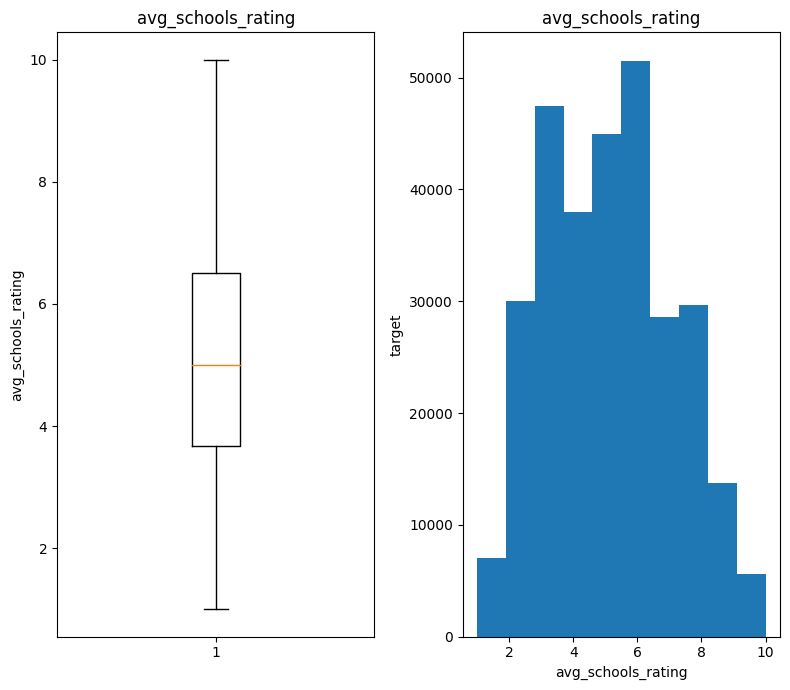

In [61]:
# Удаление выбросов признака  avg_schools_rating
condition_6 = df['avg_schools_rating'] < 0
df.drop(df[condition_6].index, inplace=True)

outliers6, cleaned6 = find_outliers_iqr(df, 'avg_schools_rating', left=2, right=2, log_scale=False)
print(f'Число выбросов по методу Тьюки: {outliers6.shape[0]}')
print(f'Результирующее число записей: {cleaned6.shape[0]}')

df = df.drop(outliers6.index)

# График после удаления выбросов
num_features_1 = ['avg_schools_rating']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='avg_schools_rating')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    image_filename = os.path.join(output_directory, f'2_{feature}_plot.png')
    fig.savefig(image_filename)

### Признак beds_overall

In [62]:
# Удаление явных выбросов
condition_5 = df['beds_overall'] > 100

df.drop(df[condition_5].index, inplace=True)

Воспользуемся методом межквартильного размаха для обнаружения и удаления выбросов.

In [63]:
# Удаление выбросов с помошью функции find_outliers_iqr
outliers4, cleaned4 = find_outliers_iqr(df, 'beds_overall', left=2, right=2, log_scale=False)
print(f'Число выбросов по методу Тьюки: {outliers4.shape[0]}')
print(f'Результирующее число записей: {cleaned4.shape[0]}')

df = df.drop(outliers4.index)

Число выбросов по методу Тьюки: 864
Результирующее число записей: 295792


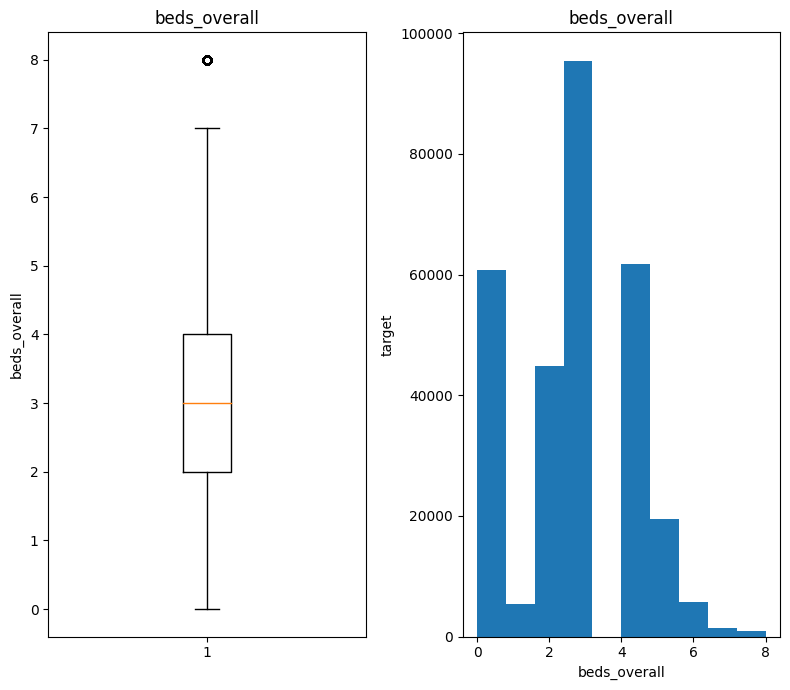

In [64]:
# График после удаления выбросов
num_features_1 = ['beds_overall']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='beds_overall')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    image_filename = os.path.join(output_directory, f'3_{feature}_plot.png')
    fig.savefig(image_filename)

### Признак target

Признак содержит сведения о низкой цене, вероятно - цена аренды. Удалим значения таргета ниже 500 $, как аномальные.

In [65]:
# Удаление значений с аномальной и аномально высокой ценой
df = df.drop(df[df['target'] < 500].index)

df = df.drop(df[df['target'] > 100000000].index)

In [66]:
df = df.drop(df[df['target'] > 100000000].index)

Признак target содержит много противоречивых данных - маленькая цена при большой площади, и наоборот. Они будут ухудшать прогностические возможности новой модели обучения. Удалим выбросы с помощью метода межквартильного размаха.

In [67]:
# Удаление выбросов  в target
outliers_tg, cleaned_tg = find_outliers_iqr(df, 'target', left=3, right=3, log_scale=False)
print(f'Число выбросов по методу Тьюки: {outliers_tg.shape[0]}')
print(f'Результирующее число записей: {cleaned_tg.shape[0]}')

df = df.drop(outliers_tg.index)

Число выбросов по методу Тьюки: 15489
Результирующее число записей: 280292


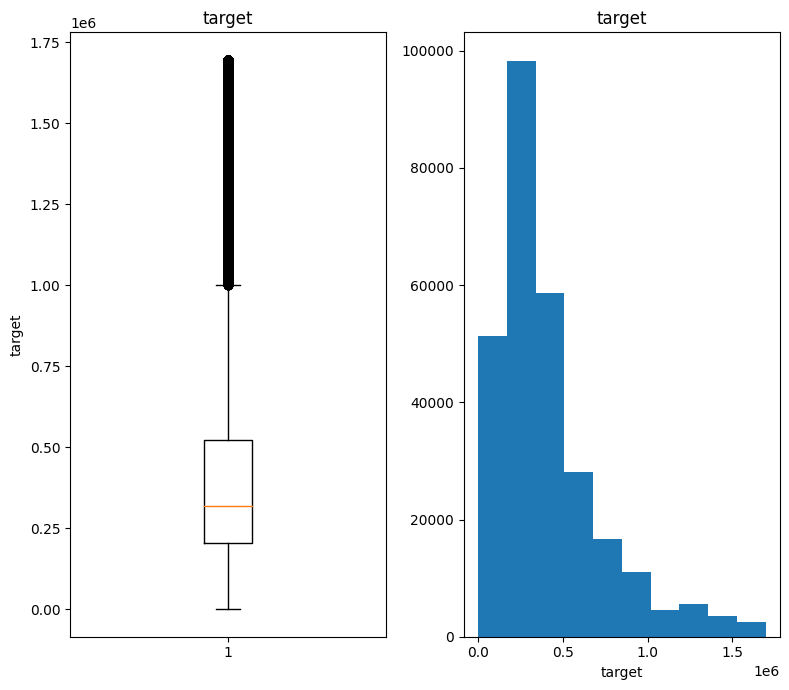

In [68]:
# График после удаления выбросов
num_features_1 = ['target']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='target')
    ax2.set_xlabel(feature)
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    image_filename = os.path.join(output_directory, f'2_{feature}_plot.png')
    fig.savefig(image_filename)

### Анализ категориальных признаков

In [69]:
# Список категоричальных признаков:
cat_features = ['status', 'propertyType', 'street', 'zipcode', 'state', 'city', 'Year built']
df.describe(include = 'object')

,status,propertyType,street,city,zipcode,state,Year built
count,280292,280292,280292,280292,280292,280292,280292
unique,13,10,250033,1631,3956,35,211
top,For sale,single family,Address Not Disclosed,Houston,33131,FL,2019
freq,158488,164168,550,21031,1385,82249,25860


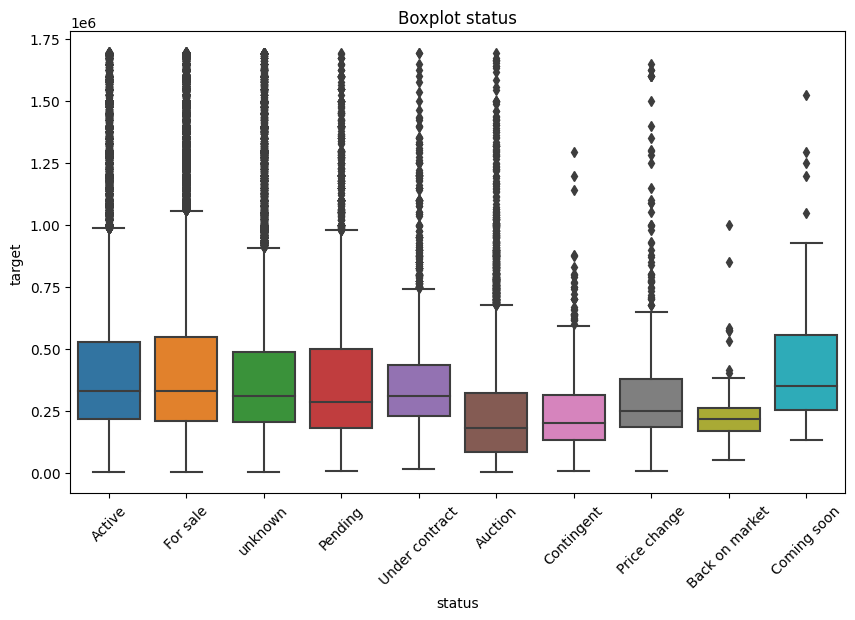

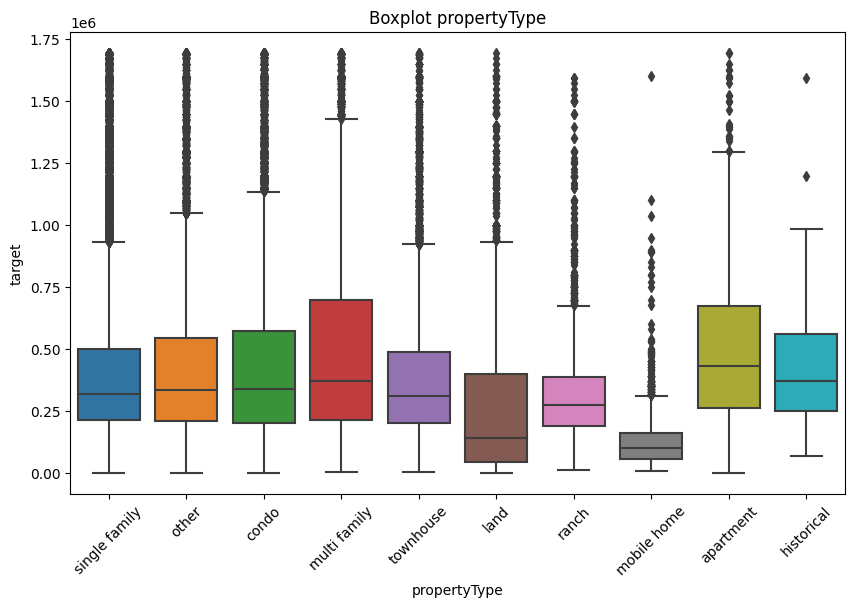

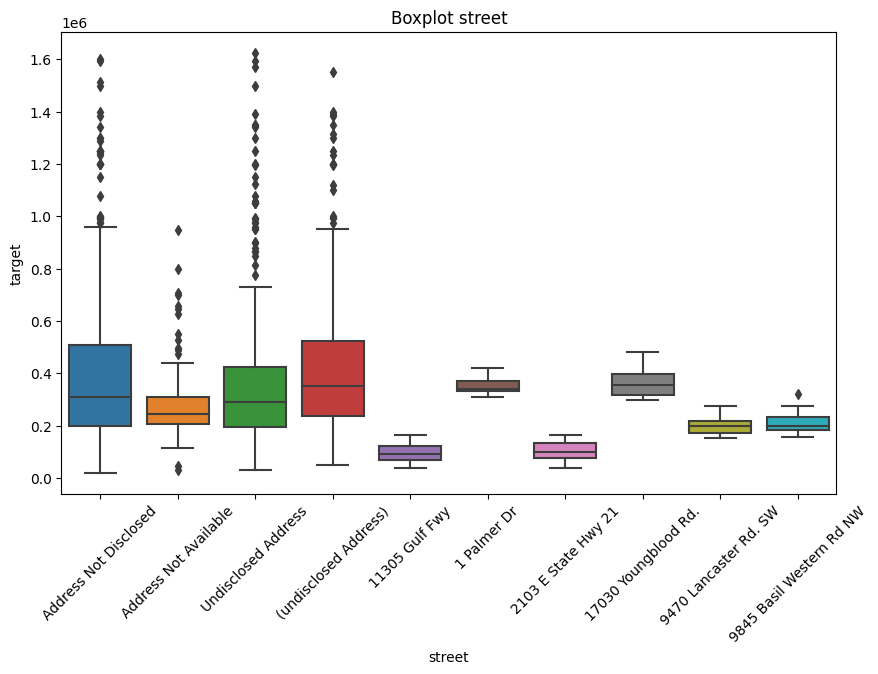

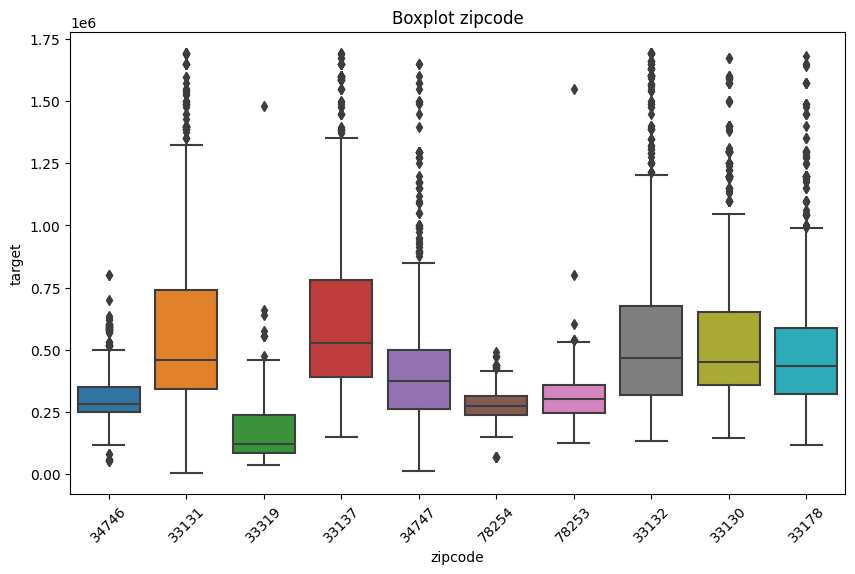

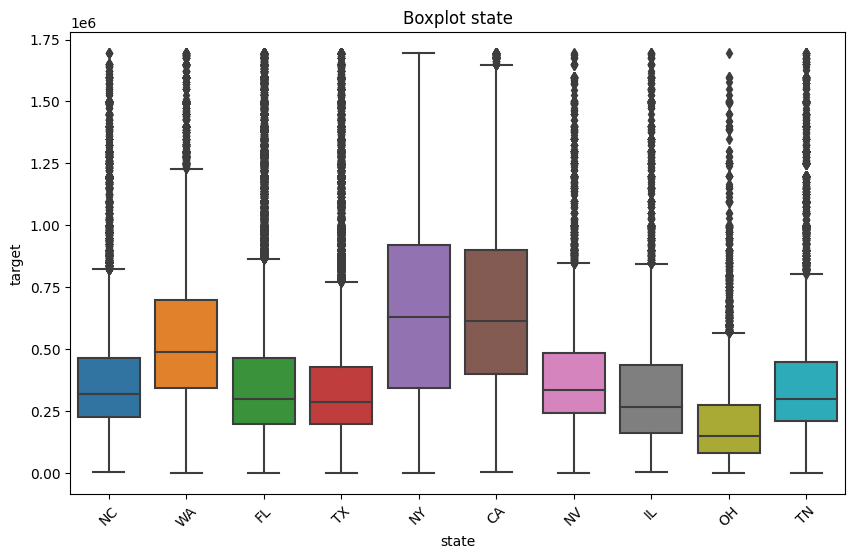

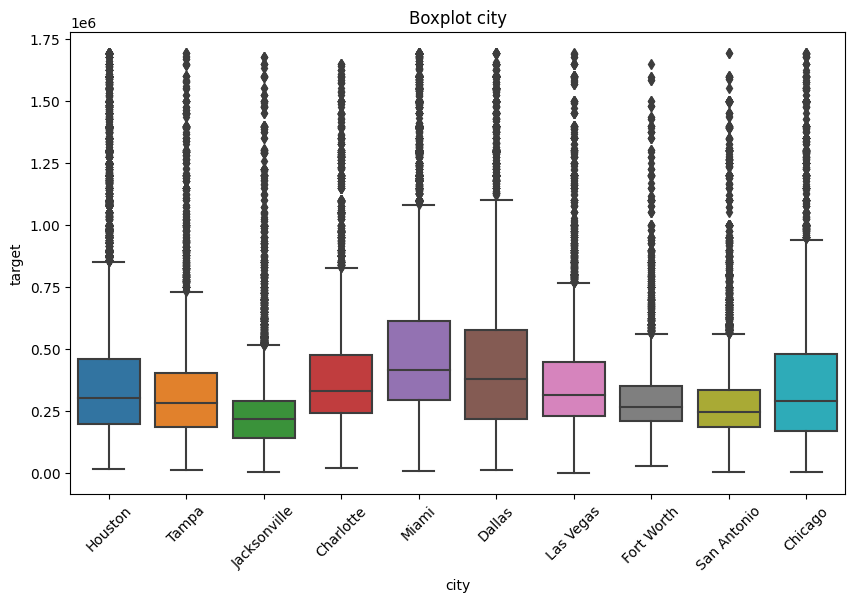

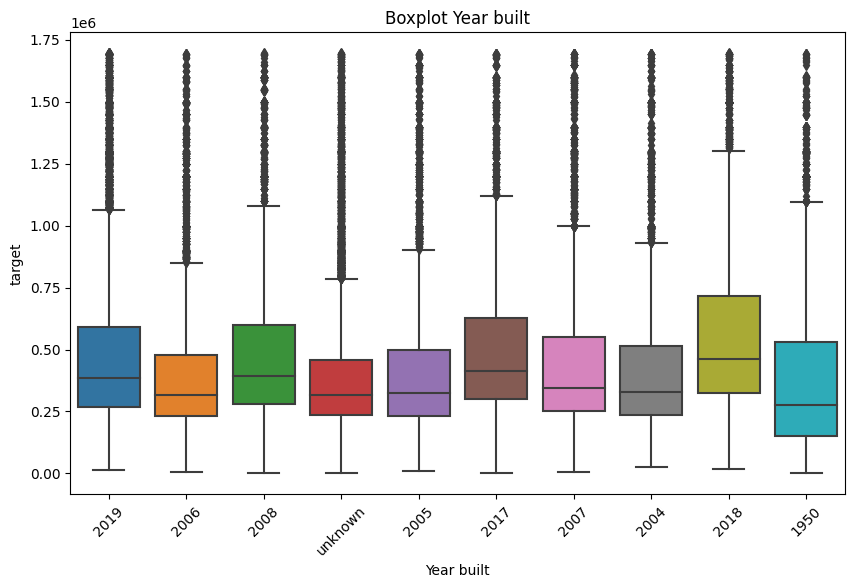

In [70]:
cat_features = ['status', 'propertyType', 'street', 'zipcode', 'state', 'city', 'Year built']
for cat in cat_features:
    fig, ax = plt.subplots(figsize = (10, 6))
    sns.boxplot(x=cat, y='target', data=df.loc[df.loc[:, cat].isin(df.loc[:, cat].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot ' + cat)
    plt.show()
    
    image_filename = os.path.join(output_directory, f'5_{cat}_plot.png')
    fig.savefig(image_filename)

По графикам видно, что большинство категориальных признаков (кроме street) могут влиять на target.

In [71]:
# Удаление признака street
df = df.drop('street', axis=1)

## Проектирование признаков

### Оценка мультиколлинеарности

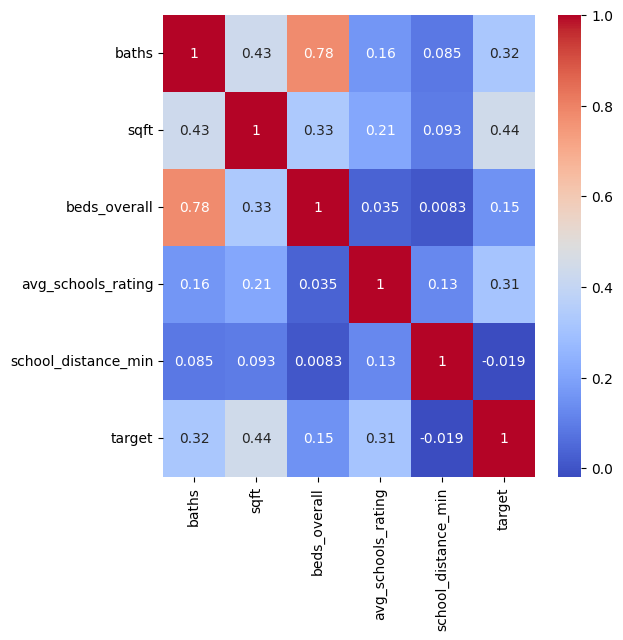

In [72]:
fig, (ax) = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(df[num_features].corr(), annot = True, cmap='coolwarm')

fig.savefig('graph/corr_matrix.png')

Наблюдается сильная коллинеарность у двух признаков baths и beds_overall. Удалим количество спален, потому что оно слабее коррелирует с target.  Baths оставляем.

In [73]:
# Удаляем столбец beds_overall
df = df.drop('beds_overall', axis=1)

### Нормализация

Так как у нас признаки разпределены ненормально, то будем использовать RobustScaler для нормализации числовых признаков.

In [74]:
# Создание объекта RobustScaler
#scaler = RobustScaler()

# Признаки для нормализации
#col_names = ['sqft', 'baths', 'avg_schools_rating', 'school_distance_min', 'target']

# Произведите нормализацию и преобразуйте данные обратно в DataFrame
#df[col_names] = scaler.fit_transform(df[col_names])

In [75]:
# Исследование распределение признаков после нормализации
#fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
#ax1.set_title('Распределение признаков после нормализации RobustScaler')

#sns.kdeplot(df['sqft'], ax=ax1, label='sqft')
#sns.kdeplot(df['baths'], ax=ax1, label='baths')
#sns.kdeplot(df['avg_schools_rating'], ax=ax1, label='avg_schools_rating')
#sns.kdeplot(df['school_distance_min'], ax=ax1, label='school_distance_min')
#sns.kdeplot(df['target'], ax=ax1, label='target')
#ax1.legend()

#plt.savefig('graph/6_RobustScaler.png')
#plt.show()


После нормализации признаки распределены более-менее нормально (за исключением baths), но несимметрично. Коммитю, график сохранил. Проведу логарифмирование признаков.

In [76]:
# Логарифмирование данных
for col in col_names:
        df[col] = df[col].apply(lambda x: abs(x))
        constant = 1e-6
        df[col] = np.log(df[col] + constant)
df

,status,propertyType,baths,city,sqft,zipcode,state,target,private_pool,avg_schools_rating,school_distance_min,Year built
0,Active,single family,1.252763,Southern Pines,7.972466,28387,NC,12.943237,False,1.648659,0.993252,2019
1,For sale,single family,1.098613,Spokane Valley,7.574045,99216,WA,12.644328,False,1.386295,0.009951,2019
6,Active,other,-13.815511,POINCIANA,7.317876,34759,FL,12.109011,False,0.847298,-0.223142,2006
9,unknown,single family,1.098613,Houston,7.565275,77080,TX,12.650742,False,1.098613,-0.510824,2019
10,For sale,condo,0.693148,Flushing,7.170120,11354,NY,13.413539,False,1.897120,-1.203969,1965
...,...,...,...,...,...,...,...,...,...,...,...,...
374243,For sale,condo,1.098613,Washington,7.256297,20001,DC,13.591116,False,1.098613,-2.302575,2010
374244,unknown,single family,1.791760,Miami,8.298291,33180,FL,14.037854,True,2.014903,0.095311,1990
374245,For sale,condo,1.098613,Chicago,7.600902,60657,IL,13.422466,False,1.466337,-0.916288,1924
374246,For sale,single family,1.098613,Jamaica,7.049255,11434,NY,13.176852,False,1.504078,-0.733967,1950


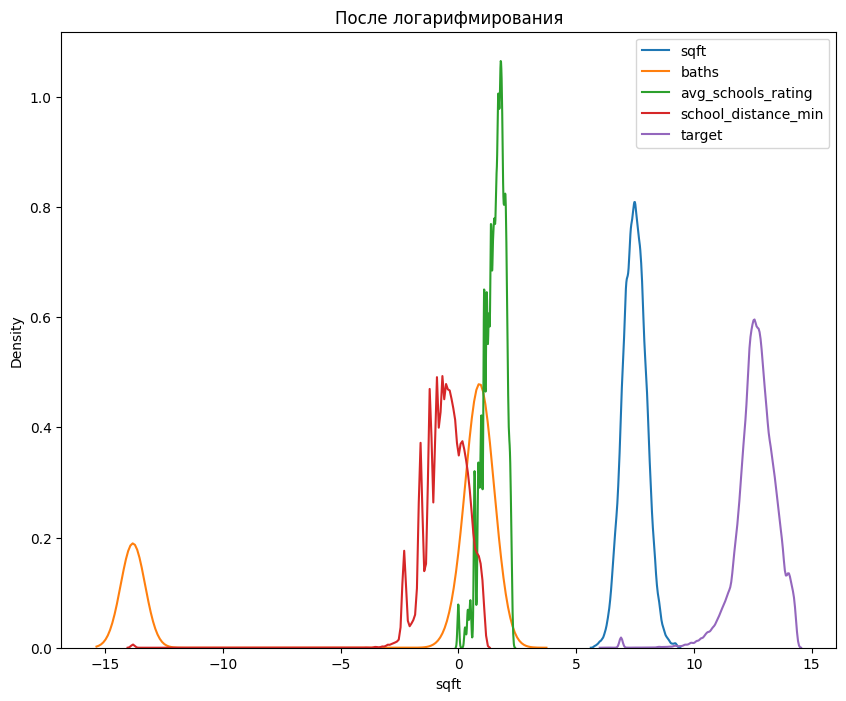

In [77]:
# Исследование графиков на предмет, как изменилось распределение признаков после логарифмирования
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('После логарифмирования')

sns.kdeplot(df['sqft'], ax=ax1, label='sqft')
sns.kdeplot(df['baths'], ax=ax1, label='baths')
sns.kdeplot(df['avg_schools_rating'], ax=ax1, label='avg_schools_rating')
sns.kdeplot(df['school_distance_min'], ax=ax1, label='school_distance_min')
sns.kdeplot(df['target'], ax=ax1, label='target')
ax1.legend()

plt.savefig("graph/6_log.png")
plt.show()

Оставлю логарифмирование.

## Кодирование категориальных признаков

In [78]:
# Сохранение предобработанные данные в CSV-файл для работы в CatBoost без кодировки категориальных признаков
df.to_csv("data/cleaned_data_for_CatBoost.csv", index=False)

Продолжаем работу. Читаем файл с данными для дальнейшего кодирования.

In [79]:
df = pd.read_csv('data/cleaned_data_for_CatBoost.csv')
df.head()

,status,propertyType,baths,city,sqft,zipcode,state,target,private_pool,avg_schools_rating,school_distance_min,Year built
0,Active,single family,1.252763,Southern Pines,7.972466,28387,NC,12.943237,False,1.648659,0.993252,2019
1,For sale,single family,1.098613,Spokane Valley,7.574045,99216,WA,12.644328,False,1.386295,0.009951,2019
2,Active,other,-13.815511,POINCIANA,7.317876,34759,FL,12.109011,False,0.847298,-0.223142,2006
3,unknown,single family,1.098613,Houston,7.565275,77080,TX,12.650742,False,1.098613,-0.510824,2019
4,For sale,condo,0.693148,Flushing,7.170120,11354,NY,13.413539,False,1.897120,-1.203969,1965


In [80]:
df.describe(include = 'object')

,status,propertyType,city,state,Year built
count,280292,280292,280292,280292,280292
unique,13,10,1631,35,211
top,For sale,single family,Houston,FL,2019
freq,158488,164168,21031,82249,25860


Будем кодировать:
1. Однократное кодирование OneHotEncoder: status, propertyType
2. Остальное кодируем LabelEncoder (city, zipcode, state, Year built)

In [81]:
# Однократное кодирование
df_encoded = pd.get_dummies(df, columns=['status', 'propertyType'])
df_encoded.head()

,baths,city,sqft,zipcode,state,target,private_pool,avg_schools_rating,school_distance_min,Year built,...,propertyType_apartment,propertyType_condo,propertyType_historical,propertyType_land,propertyType_mobile home,propertyType_multi family,propertyType_other,propertyType_ranch,propertyType_single family,propertyType_townhouse
0,1.252763,Southern Pines,7.972466,28387,NC,12.943237,False,1.648659,0.993252,2019,...,False,False,False,False,False,False,False,False,True,False
1,1.098613,Spokane Valley,7.574045,99216,WA,12.644328,False,1.386295,0.009951,2019,...,False,False,False,False,False,False,False,False,True,False
2,-13.815511,POINCIANA,7.317876,34759,FL,12.109011,False,0.847298,-0.223142,2006,...,False,False,False,False,False,False,True,False,False,False
3,1.098613,Houston,7.565275,77080,TX,12.650742,False,1.098613,-0.510824,2019,...,False,False,False,False,False,False,False,False,True,False
4,0.693148,Flushing,7.170120,11354,NY,13.413539,False,1.897120,-1.203969,1965,...,False,True,False,False,False,False,False,False,False,False


In [82]:
# Кодирование оставшихся признаков с помощью LabelEncoder
state_le = LabelEncoder()
state_label = state_le.fit_transform(df_encoded['state'])

yearb_le = LabelEncoder()
yearb_label = yearb_le.fit_transform(df_encoded['Year built'])

city_le = LabelEncoder()
city_label = city_le.fit_transform(df_encoded['city'])

zipcode_le = LabelEncoder()
zipcode_label = zipcode_le.fit_transform(df_encoded['zipcode'])

# Добавление закодированные признаков в дата фрейм
df_encoded['state_label'] = state_label
df_encoded['year_label'] = yearb_label
df_encoded['city_label'] = city_label
df_encoded['zipcode_label'] = zipcode_label

# Удаление отработанных признаков
df_encoded.drop(['state', 'city', 'zipcode','Year built'], axis=1, inplace=True)

In [83]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280292 entries, 0 to 280291
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   baths                       280292 non-null  float64
 1   sqft                        280292 non-null  float64
 2   target                      280292 non-null  float64
 3   private_pool                280292 non-null  bool   
 4   avg_schools_rating          280292 non-null  float64
 5   school_distance_min         280292 non-null  float64
 6   status_Active               280292 non-null  bool   
 7   status_Auction              280292 non-null  bool   
 8   status_Back on market       280292 non-null  bool   
 9   status_Closed               280292 non-null  bool   
 10  status_Coming soon          280292 non-null  bool   
 11  status_Contingent           280292 non-null  bool   
 12  status_For rent             280292 non-null  bool   
 13  status_For sal

In [84]:
# Сохранение предобработанных данных в CSV-файл
df_encoded.to_csv("data/eda_data.csv", index=False)

## Итоги по разведывательному анализу EDA
- исследовал взаимосвязи между признаками и таргетом;
- исследовал числовые признаки, нашел и удалил выбросы и скрытые пропуски;
- исследовал категориальные признаки;
- проверил признаки на мультиколлинеарность, устранил один из признаков с сильной корреляцией;
- провел логарифмирование признаков;
- провел кодирование признаков;
- сохраняю файл в CSV-файл для дальнейшего построения модели машинного обучения.